In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
lots = pd.read_csv('tba_lots.csv')

In [33]:
lots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505127 entries, 0 to 1505126
Data columns (total 24 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   lot_id                    1496774 non-null  object 
 1   auction_id                1504928 non-null  float64
 2   auction_start_time        1505127 non-null  object 
 3   auction_close_time        1505127 non-null  object 
 4   lot_close_time_actual     715452 non-null   object 
 5   estimated_price           1503911 non-null  float64
 6   starting_price            1505127 non-null  float64
 7   is_delivery               1505127 non-null  int64  
 8   auction_country           1504966 non-null  object 
 9   lot_quantity              1503911 non-null  float64
 10  lot_title                 1487192 non-null  object 
 11  lot_description           893775 non-null   object 
 12  appearance                1479751 non-null  object 
 13  condition                 1

In [34]:
lots = lots.dropna(subset=['lot_quantity', 'estimated_price', 'nr_bids','highest_valid_bid_amount','nr_valid_bid_users'])
lots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1100104 entries, 0 to 1505124
Data columns (total 24 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   lot_id                    1100104 non-null  object 
 1   auction_id                1100083 non-null  float64
 2   auction_start_time        1100104 non-null  object 
 3   auction_close_time        1100104 non-null  object 
 4   lot_close_time_actual     555944 non-null   object 
 5   estimated_price           1100104 non-null  float64
 6   starting_price            1100104 non-null  float64
 7   is_delivery               1100104 non-null  int64  
 8   auction_country           1100104 non-null  object 
 9   lot_quantity              1100104 non-null  float64
 10  lot_title                 1087427 non-null  object 
 11  lot_description           844423 non-null   object 
 12  appearance                1082045 non-null  object 
 13  condition                 108208

In [35]:
# Filtering the lots to show only duplicate rows based on 'lot_id'
duplicates = lots[lots['lot_id'].duplicated(keep=False)]  # `keep=False` marks all duplicates as True
print(duplicates)
## lots data does not contain duplicate lot ids

Empty DataFrame
Columns: [lot_id, auction_id, auction_start_time, auction_close_time, lot_close_time_actual, estimated_price, starting_price, is_delivery, auction_country, lot_quantity, lot_title, lot_description, appearance, condition, packaging, assigned_explicitly, category_id, is_offered, is_sold, platform, has_bids, nr_bids, highest_valid_bid_amount, nr_valid_bid_users]
Index: []

[0 rows x 24 columns]


In [36]:
lots.describe()

,auction_id,estimated_price,starting_price,is_delivery,lot_quantity,category_id,is_offered,is_sold,has_bids,nr_bids,highest_valid_bid_amount,nr_valid_bid_users
count,1.100083e+06,1.100104e+06,1.100104e+06,1.100104e+06,1.100104e+06,1.098693e+06,1.100104e+06,1.100104e+06,1100104.0,1.100104e+06,1.100104e+06,1.100104e+06
mean,9.828607e+05,1.177119e+03,2.929235e+02,1.095224e-01,6.405275e+01,3.808760e+03,9.980647e-01,8.340457e-01,1.0,1.381931e+01,9.826710e+02,4.911453e+00
std,8.391768e+04,1.919679e+04,4.364894e+03,3.122936e-01,3.197952e+04,1.040919e+03,4.394915e-02,3.720398e-01,0.0,1.563352e+01,8.449564e+03,4.046898e+00
min,2.892030e+05,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00
25%,9.001330e+05,1.000000e+01,1.000000e+01,0.000000e+00,1.000000e+00,3.052000e+03,1.000000e+00,1.000000e+00,1.0,2.000000e+00,4.000000e+01,2.000000e+00
50%,9.791750e+05,6.000000e+01,1.500000e+01,0.000000e+00,1.000000e+00,3.525000e+03,1.000000e+00,1.000000e+00,1.0,8.000000e+00,1.050000e+02,4.000000e+00
75%,1.072333e+06,2.500000e+02,1.000000e+02,0.000000e+00,1.000000e+00,4.522000e+03,1.000000e+00,1.000000e+00,1.0,2.000000e+01,3.200000e+02,7.000000e+00
max,1.117122e+06,1.000000e+07,2.250000e+06,1.000000e+00,3.312331e+07,6.650000e+03,1.000000e+00,1.000000e+00,1.0,2.130000e+02,5.000000e+06,6.000000e+01


In [37]:
percentile_95 = lots['lot_quantity'].quantile(0.95)
# Filter  lots to discard data above the 95th percentile of lot_quantity
lots = lots[lots['lot_quantity'] <= percentile_95]

# Delete the data whose lot quantity is 0
lots = lots[lots['lot_quantity'] != 0]

## First strategy: Fill in with average estmated price

In [10]:
# estimated price'ı 0 olan lotlara asssign et = o categorideki ürünlerin estimated price'ı / o categorideki total lottaki ürün sayısı
# Step 1: Filter the DataFrame where estimated_price is less than 1
filtered_data = lots[lots['estimated_price'] > 5]

# Step 2: Group by 'category_id' and 'lot_quantity' and calculate the average estimated price
average_prices = filtered_data.groupby(['category_id', 'lot_quantity'])['estimated_price'].mean().reset_index()

# Rename the column for clarity when merging
average_prices.rename(columns={'estimated_price': 'average_estimated_price'}, inplace=True)

# Step 3: Merge this average back to the original DataFrame
lots = lots.merge(average_prices, on=['category_id', 'lot_quantity'], how='left')

# Step 4: Update estimated_price where it was less than 1
lots.loc[lots['estimated_price'] < 6, 'estimated_price'] = lots['average_estimated_price']

# Step 5: Clean up the DataFrame by dropping the temporary average column
lots.drop(columns=['average_estimated_price'], inplace=True)

## Second strategy: Fill in estimated price smaller than starting price with starting price

In [39]:
lots.loc[lots['estimated_price'] < lots['starting_price'], 'estimated_price'] = lots['starting_price']


In [40]:
filtered_data = lots[lots['estimated_price'] > 0]

# Step 2: Group by 'category_id' and 'lot_quantity' and calculate the average estimated price
average_prices = filtered_data.groupby(['category_id', 'lot_quantity', 'condition'])['estimated_price'].mean().reset_index()

# Rename the column for clarity when merging
average_prices.rename(columns={'estimated_price': 'average_estimated_price'}, inplace=True)

# Step 3: Merge this average back to the original DataFrame
lots = lots.merge(average_prices, on=['category_id', 'lot_quantity','condition'], how='left')

# Step 4: Update estimated_price where it was less than 1
lots.loc[lots['estimated_price'] < 1, 'estimated_price'] = lots['average_estimated_price']

# Step 5: Clean up the DataFrame by dropping the temporary average column
lots.drop(columns=['average_estimated_price'], inplace=True)

## Creating a measure for auction performance

In [9]:
lots['log_auction_performance'] = np.log((lots['highest_valid_bid_amount'] *lots['nr_bids'] *lots['nr_valid_bid_users'] )/(lots['estimated_price']+1e-10) )



(array([3.00000e+00, 1.91000e+02, 5.37570e+04, 2.79864e+05, 3.50863e+05,
        3.04804e+05, 5.02940e+04, 6.27200e+03, 4.59000e+02, 1.90000e+01]),
 array([-9.83894903, -6.91843994, -3.99793085, -1.07742177,  1.84308732,
         4.76359641,  7.6841055 , 10.60461459, 13.52512368, 16.44563276,
        19.36614185]),
 <BarContainer object of 10 artists>)

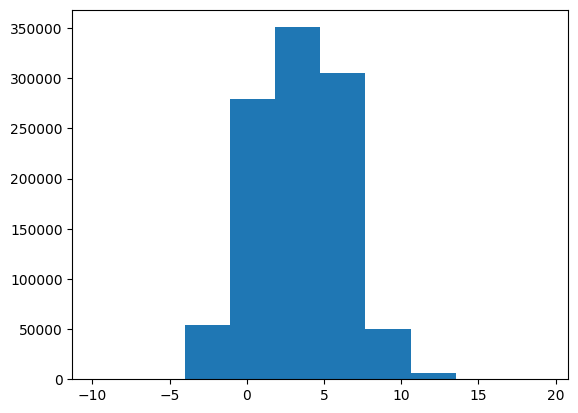

In [10]:
plt.hist(lots['log_auction_performance'])

In [11]:
lots['auction_performance'] = (lots['highest_valid_bid_amount'] *lots['nr_bids'] *lots['nr_valid_bid_users'] )/(lots['estimated_price']+1e-10)

(array([1.046512e+06, 6.000000e+00, 2.000000e+00, 2.000000e+00,
        1.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00]),
 array([5.33333333e-05, 2.57400000e+07, 5.14800000e+07, 7.72200000e+07,
        1.02960000e+08, 1.28700000e+08, 1.54440000e+08, 1.80180000e+08,
        2.05920000e+08, 2.31660000e+08, 2.57400000e+08]),
 <BarContainer object of 10 artists>)

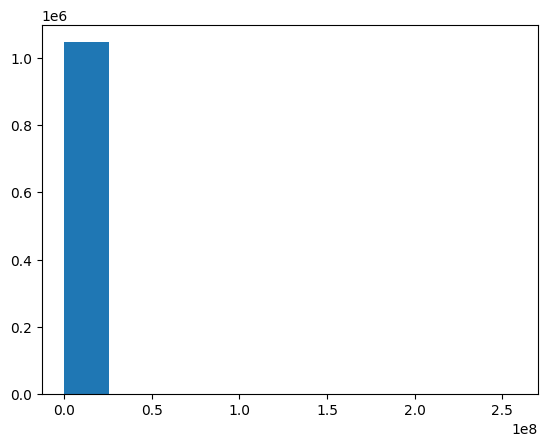

In [12]:
plt.hist(lots['auction_performance'])

#### Log performance seems more reasonable and informative therefore continue with log performance

In [13]:
lots.drop(columns=['auction_performance'], inplace=True)

## Visualizations

### Performance by Country

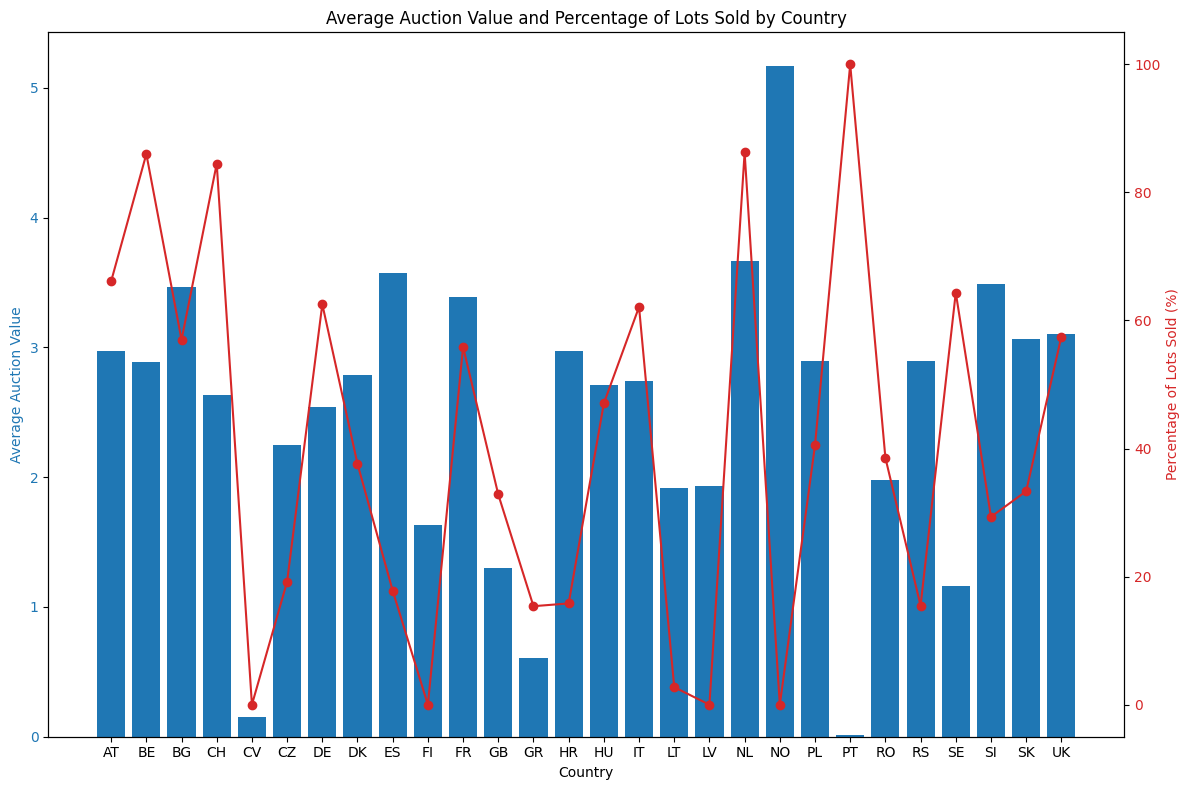

In [14]:
lots['auction_country'] = lots['auction_country'].str.upper()


country_stats = lots.groupby('auction_country').agg(
    Total_Lots=('is_sold', 'size'),
    Sold_Lots=('is_sold', 'sum'),
    Average_Auction_Value=('log_auction_performance', 'mean')
).assign(
    Sold_Percentage=lambda x: (x['Sold_Lots'] / x['Total_Lots']) * 100
)

# Reset index to make 'Country' a column again for easier plotting
country_stats.reset_index(inplace=True)

# Creating a plot with a twin axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for average auction value
color = 'tab:blue'
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Auction Value', color=color)
ax1.bar(country_stats['auction_country'], country_stats['Average_Auction_Value'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Percentage of Lots Sold (%)', color=color)  
ax2.plot(country_stats['auction_country'], country_stats['Sold_Percentage'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

# Title and custom x-axis tick labels
plt.title('Average Auction Value and Percentage of Lots Sold by Country')
fig.tight_layout()  # To ensure there's no overlap
plt.xticks(rotation=45)  # Rotates country names for better readability
plt.show()

##### Country seems informative in determining the performance

### Performance by day of a week and month

In [15]:
# Fix the date format 
lots['auction_start_time'] = pd.to_datetime(lots['auction_start_time'])

# Add new columns for the day of the week and the month
lots['auction_day_of_week'] = lots['auction_start_time'].dt.day_name()
lots['auction_month'] = lots['auction_start_time'].dt.month_name()

C:\Users\90538\AppData\Local\Temp\ipykernel_14000\3126756448.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=performance_by_day.index, y=performance_by_day.values, palette='viridis')


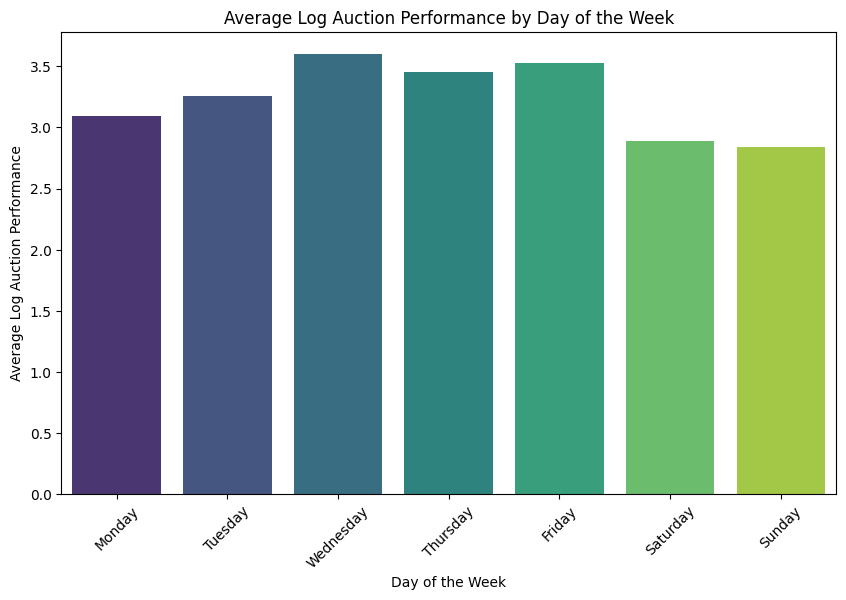

In [16]:
# Group by 'day_of_week' to calculate mean log_auction_performance
performance_by_day = lots.groupby('auction_day_of_week')['log_auction_performance'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plotting the average log_auction_performance by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=performance_by_day.index, y=performance_by_day.values, palette='viridis')
plt.title('Average Log Auction Performance by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Log Auction Performance')
plt.xticks(rotation=45)
plt.show()

C:\Users\90538\AppData\Local\Temp\ipykernel_14000\4237681354.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=performance_by_month.index, y=performance_by_month.values, palette='coolwarm')


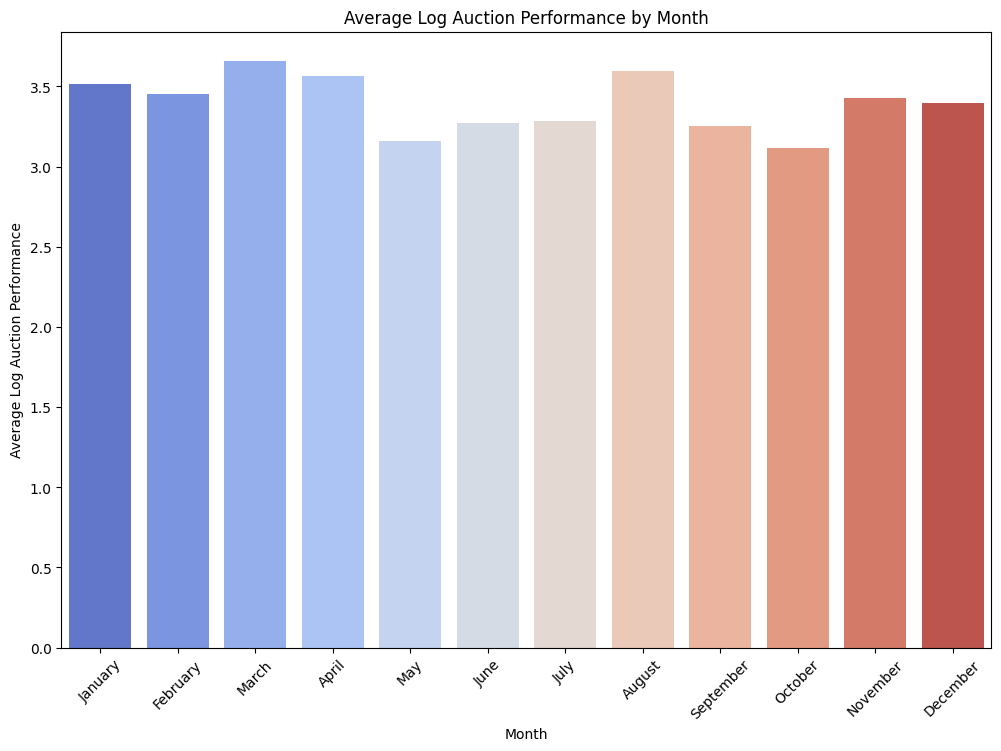

In [17]:
# Group by 'month' to calculate mean log_auction_performance
performance_by_month = lots.groupby('auction_month')['log_auction_performance'].mean().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Plotting the average log_auction_performance by month
plt.figure(figsize=(12, 8))
sns.barplot(x=performance_by_month.index, y=performance_by_month.values, palette='coolwarm')
plt.title('Average Log Auction Performance by Month')
plt.xlabel('Month')
plt.ylabel('Average Log Auction Performance')
plt.xticks(rotation=45)
plt.show()

### Performance by Category Level 1

C:\Users\90538\AppData\Local\Temp\ipykernel_14000\3647785190.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_performance.values, y=sorted_performance.index, palette='dark', orient='h')


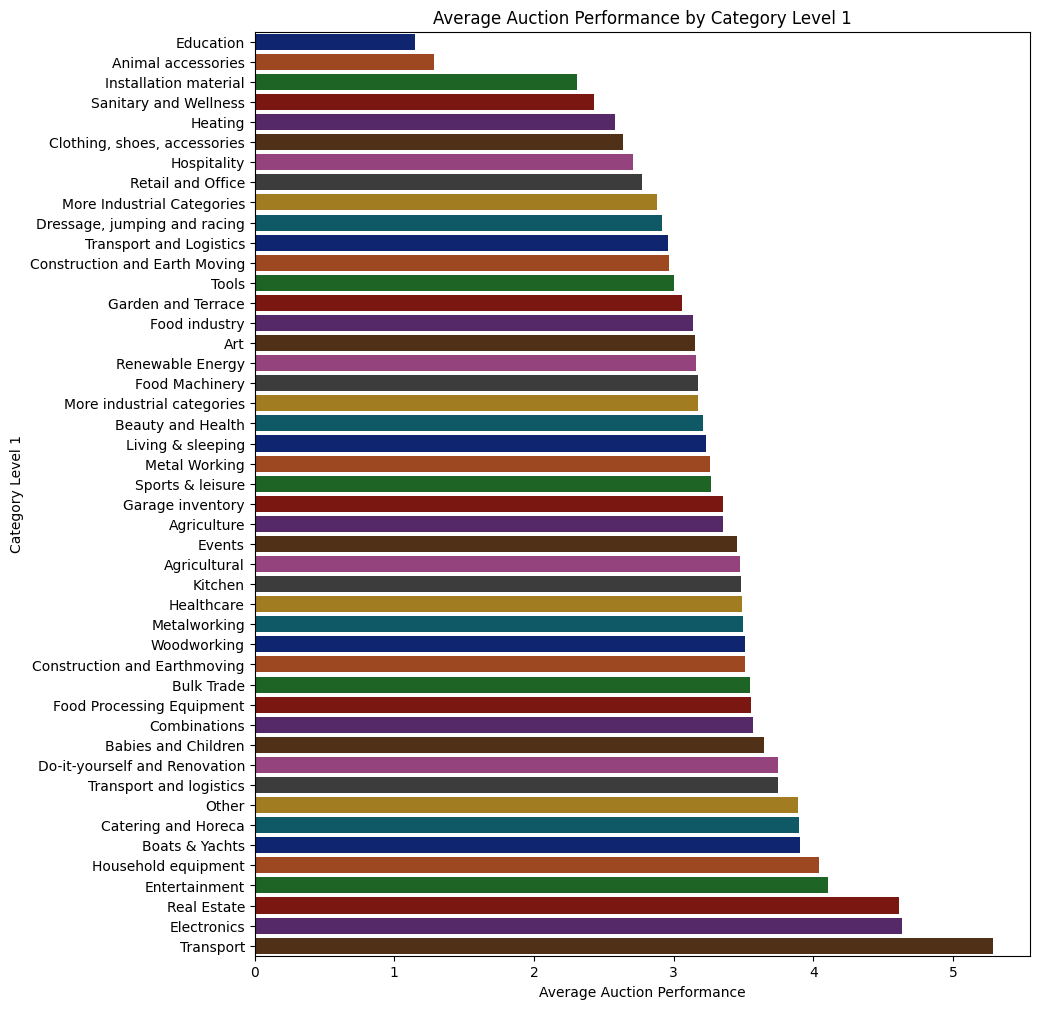

In [18]:
category_details = pd.read_csv("tba_category.csv")
# Create a mapping from category_id to category_level_1
category_map = category_details.set_index('category_id')['category_level_1'].to_dict()

lots['category_level_1'] = lots['category_id'].map(category_map)


# Calculate mean auction performance by category_level_1
performance_by_category = lots.groupby('category_level_1')['log_auction_performance'].mean()


sorted_performance = performance_by_category.sort_values()

plt.figure(figsize=(10, 12))
sns.barplot(x=sorted_performance.values, y=sorted_performance.index, palette='dark', orient='h')
plt.title('Average Auction Performance by Category Level 1')
plt.xlabel('Average Auction Performance')
plt.ylabel('Category Level 1')
plt.show()

### Feature Importance

In [19]:
features = ['starting_price','is_delivery','auction_country','lot_quantity','lot_description','appearance','condition', 'packaging','is_offered','platform','log_auction_performance', 'auction_day_of_week','auction_month', 'category_level_1']

encoded_lots = lots[features]

columns_to_encode = ['auction_country', 'platform', 'appearance','condition','packaging','auction_day_of_week','auction_month', 'category_level_1']

In [20]:
# Compute the lot_description length to see its importance in auction performance

encoded_lots['lot_description_length'] = encoded_lots['lot_description'].apply(lambda x: len(x) if pd.notna(x) else 0)
encoded_lots.drop(columns=['lot_description'], inplace=True)
encoded_lots

C:\Users\90538\AppData\Local\Temp\ipykernel_14000\1639066861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_lots['lot_description_length'] = encoded_lots['lot_description'].apply(lambda x: len(x) if pd.notna(x) else 0)
C:\Users\90538\AppData\Local\Temp\ipykernel_14000\1639066861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_lots.drop(columns=['lot_description'], inplace=True)


,starting_price,is_delivery,auction_country,lot_quantity,appearance,condition,packaging,is_offered,platform,log_auction_performance,auction_day_of_week,auction_month,category_level_1,lot_description_length
0,50.0,0,HU,1.0,NaN,NaN,NaN,1,NaN,-1.514128,Friday,January,More Industrial Categories,71
1,200.0,0,BE,1.0,NaN,NaN,NaN,1,TWK,-0.693147,Friday,September,More Industrial Categories,7
2,100.0,0,BE,1.0,NaN,NaN,NaN,1,TWK,2.890372,Friday,September,More Industrial Categories,18
3,20.0,0,BE,1.0,NaN,NaN,NaN,1,TWK,6.632002,Friday,September,More Industrial Categories,6
4,100.0,0,UK,1.0,NaN,NaN,NaN,1,TWK,-0.693147,Monday,February,Metal Working,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046521,10.0,0,NL,1.0,NOT_CHECKED,not checked,NOT_CHECKED,0,NaN,-1.203973,Thursday,February,Hospitality,0
1046522,50.0,0,NL,1.0,NOT_CHECKED,not checked,NOT_CHECKED,1,TWK,-1.609438,Thursday,February,Healthcare,47
1046523,850.0,0,BE,1.0,NOT_CHECKED,not checked,NOT_CHECKED,1,NaN,5.129390,Thursday,February,Sanitary and Wellness,0
1046524,4500.0,0,NL,1.0,SIGNS_OF_USE,working,NOT_APPLICABLE,1,NaN,6.198850,Tuesday,February,Transport,0


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Apply LabelEncoder to each column specified in columns_to_encode
for column in columns_to_encode:
    le = LabelEncoder()
    encoded_lots[column] = le.fit_transform(encoded_lots[column])

# Splitting the dataset into training and testing sets
X = encoded_lots.drop(columns=['log_auction_performance'])  # Features
y = encoded_lots['log_auction_performance']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

C:\Users\90538\AppData\Local\Temp\ipykernel_14000\2376045577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_lots[column] = le.fit_transform(encoded_lots[column])
C:\Users\90538\AppData\Local\Temp\ipykernel_14000\2376045577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_lots[column] = le.fit_transform(encoded_lots[column])
C:\Users\90538\AppData\Local\Temp\ipykernel_14000\2376045577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

RandomForestRegressor(random_state=42)

In [22]:
# Getting feature importances
importances = model.feature_importances_
feature_names = X.columns

# Creating a DataFrame to view them
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

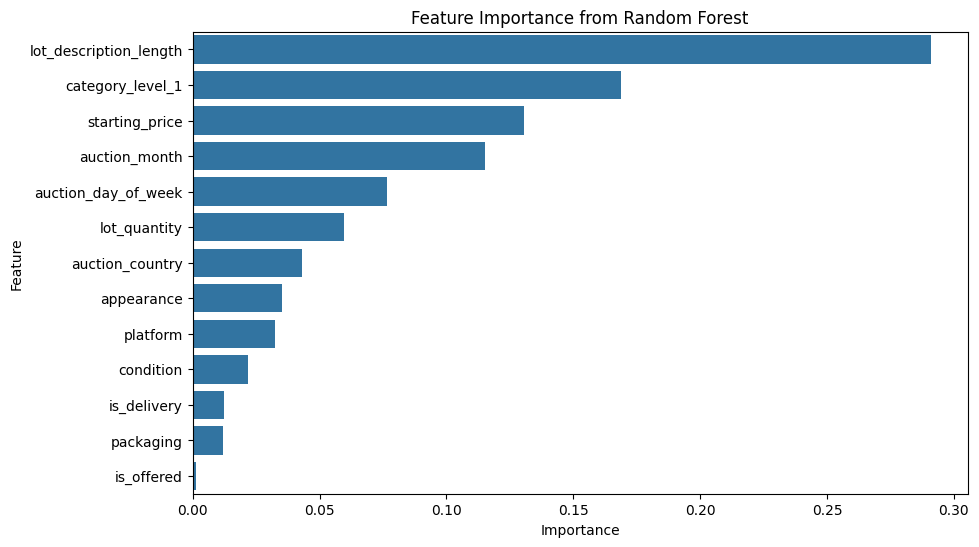

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Visualizing performance metric: ratio of estimated price and actual price

In [23]:
lots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046526 entries, 0 to 1046525
Data columns (total 28 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   lot_id                    1046526 non-null  object        
 1   auction_id                1046505 non-null  float64       
 2   auction_start_time        1046526 non-null  datetime64[ns]
 3   auction_close_time        1046526 non-null  object        
 4   lot_close_time_actual     525557 non-null   object        
 5   estimated_price           1043076 non-null  float64       
 6   starting_price            1046526 non-null  float64       
 7   is_delivery               1046526 non-null  int64         
 8   auction_country           1046526 non-null  object        
 9   lot_quantity              1046526 non-null  float64       
 10  lot_title                 1034821 non-null  object        
 11  lot_description           801029 non-null   object

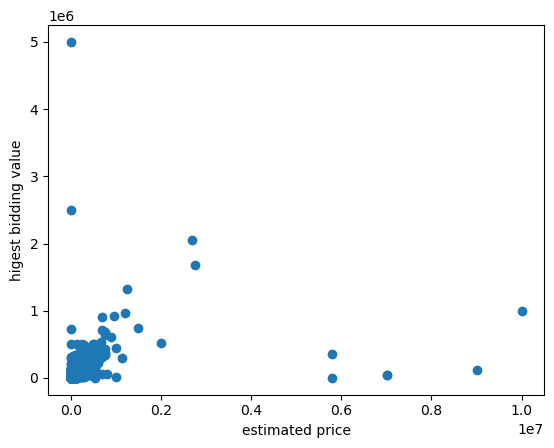

In [24]:
#Making a scatter plot that depicts the final value compaired to the estimated price
plt.scatter(lots["estimated_price"], lots["highest_valid_bid_amount"])
plt.xlabel("estimated price")
plt.ylabel("higest bidding value")
plt.show()

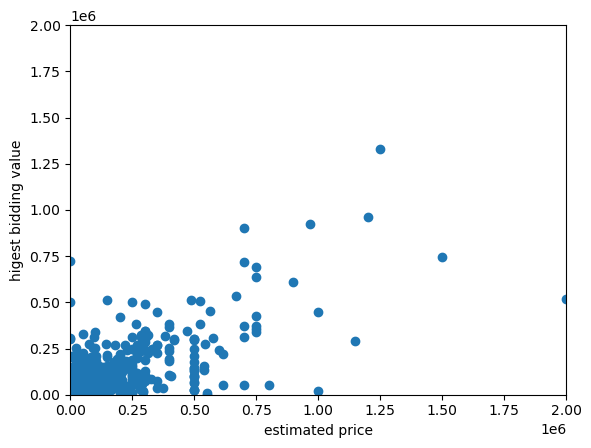

In [25]:
#Further zooming in to get a better feeling for the main body 
plt.scatter(lots["estimated_price"], lots["highest_valid_bid_amount"])
plt.xlabel("estimated price")
plt.ylabel("higest bidding value")
plt.xlim(0,2000000)
plt.ylim(0,2000000)
plt.show()

So above 250.000 euro, the relationship between estimated price and highest bidding value seem to be somewhat linear. (with some outliers, see the first graph)

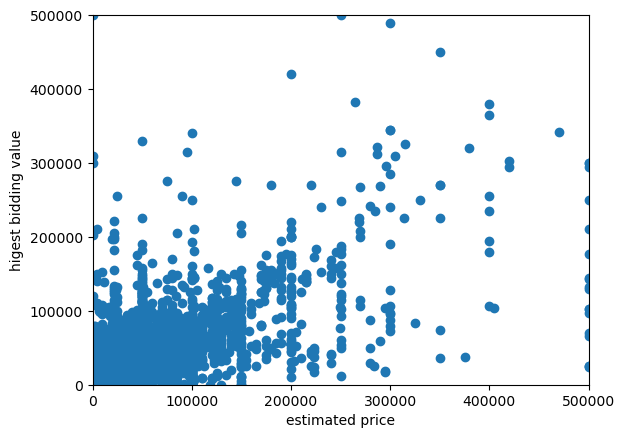

In [26]:
#Further zooming in
plt.scatter(lots["estimated_price"], lots["highest_valid_bid_amount"])
plt.xlabel("estimated price")
plt.ylabel("higest bidding value")
plt.xlim(0,500000)
plt.ylim(0,500000)
plt.show()

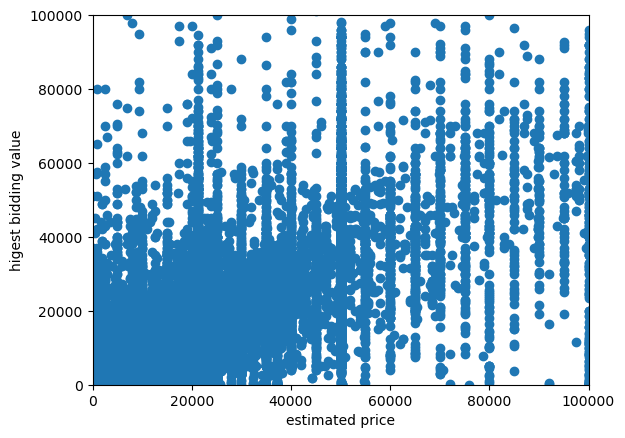

In [27]:
#Further zooming in
plt.scatter(lots["estimated_price"], lots["highest_valid_bid_amount"])
plt.xlabel("estimated price")
plt.ylabel("higest bidding value")
plt.xlim(0,100000)
plt.ylim(0,100000)
plt.show()

Seem to have a lot of round values for their estimated prices, which makes sense

In [24]:
#Defining the performance ratio by deviding the final bidding value by the estimated price
lots["ratio_estimate_actual"] = (lots["highest_valid_bid_amount"] / lots["estimated_price"])

In [29]:
#Making a histogram
lots["ratio_estimate_actual"].describe()

count    1.043076e+06
mean     2.820888e+00
std      5.501029e+02
min      1.333333e-05
25%      4.000000e-01
50%      8.333333e-01
75%      1.500000e+00
max      5.000000e+05
Name: ratio_estimate_actual, dtype: float64

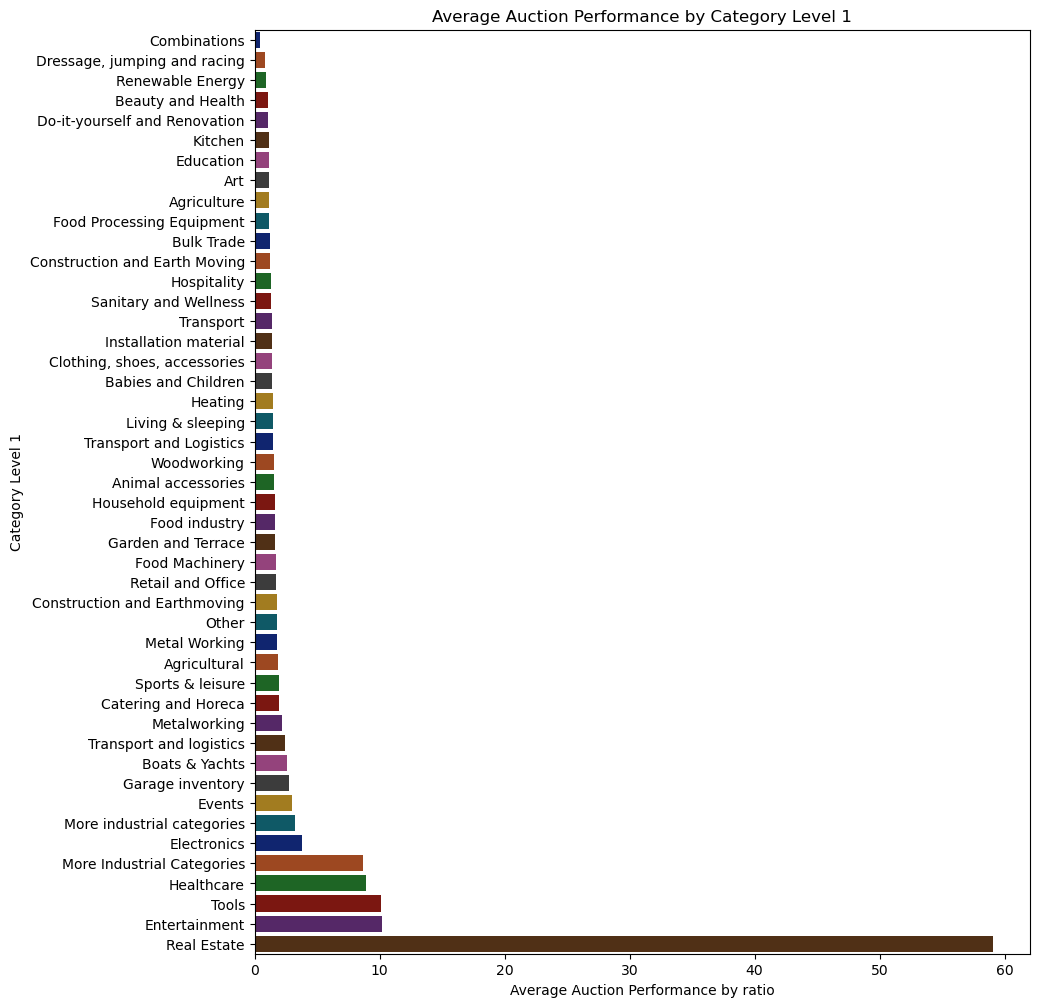

In [30]:
# Calculate mean auction performance by category_level_1 for ratio performance level
performance_by_category = lots.groupby('category_level_1')['ratio_estimate_actual'].mean()


sorted_performance = performance_by_category.sort_values()

plt.figure(figsize=(10, 12))
sns.barplot(x=sorted_performance.values, y=sorted_performance.index, palette='dark', orient='h')
plt.title('Average Auction Performance by Category Level 1')
plt.xlabel('Average Auction Performance by ratio')
plt.ylabel('Category Level 1')
plt.show()

### Feature Importance

In [27]:

encoded_lots["ratio_estimate_actual"] = lots["ratio_estimate_actual"]
encoded_lots = encoded_lots.drop(columns=['log_auction_performance'])


C:\Users\90538\AppData\Local\Temp\ipykernel_14000\815349058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_lots["ratio_estimate_actual"] = lots["ratio_estimate_actual"]


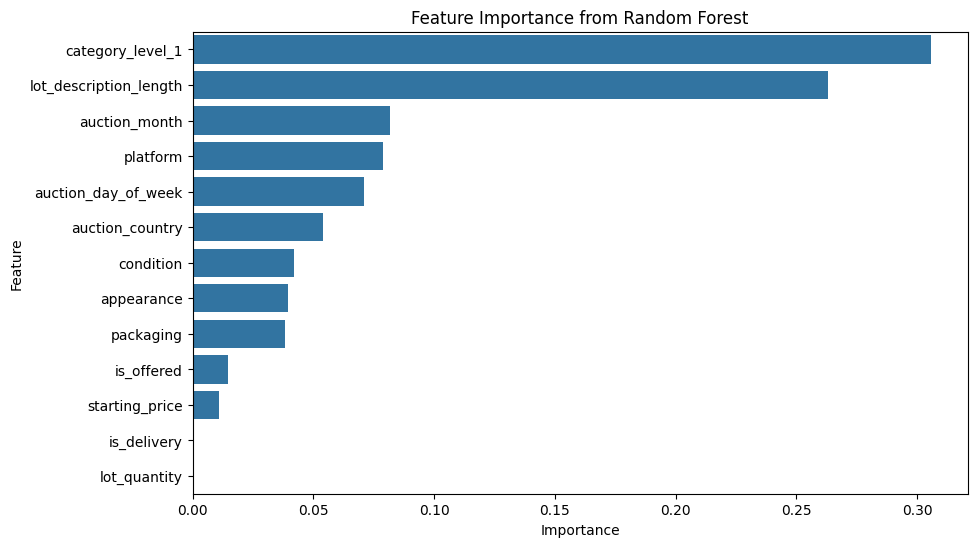

In [28]:


# Apply LabelEncoder to each column specified in columns_to_encode
for column in columns_to_encode:
    le = LabelEncoder()
    encoded_lots[column] = le.fit_transform(encoded_lots[column])

# Splitting the dataset into training and testing sets
X = encoded_lots.drop(columns=['ratio_estimate_actual'])  # Features
y = encoded_lots['ratio_estimate_actual']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Getting feature importances
importances = model.feature_importances_
feature_names = X.columns

# Creating a DataFrame to view them
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Visualizing other performance measurement

In [31]:
bids = pd.read_csv('tba_bids.csv')
bids.head()

FileNotFoundError: [Errno 2] No such file or directory: 'tba_bids.csv'

In [ ]:
bids.info()

## Scarcity



Scarcity can have a significant impact on the auction performance. I can possibly lead to increased competition, higher prices and Fear of missing out.

In [32]:
#Firstly we look to the amount of lots within a category in a certain month
lots['month_year'] = lots['auction_start_time'].dt.strftime('%Y-%m')

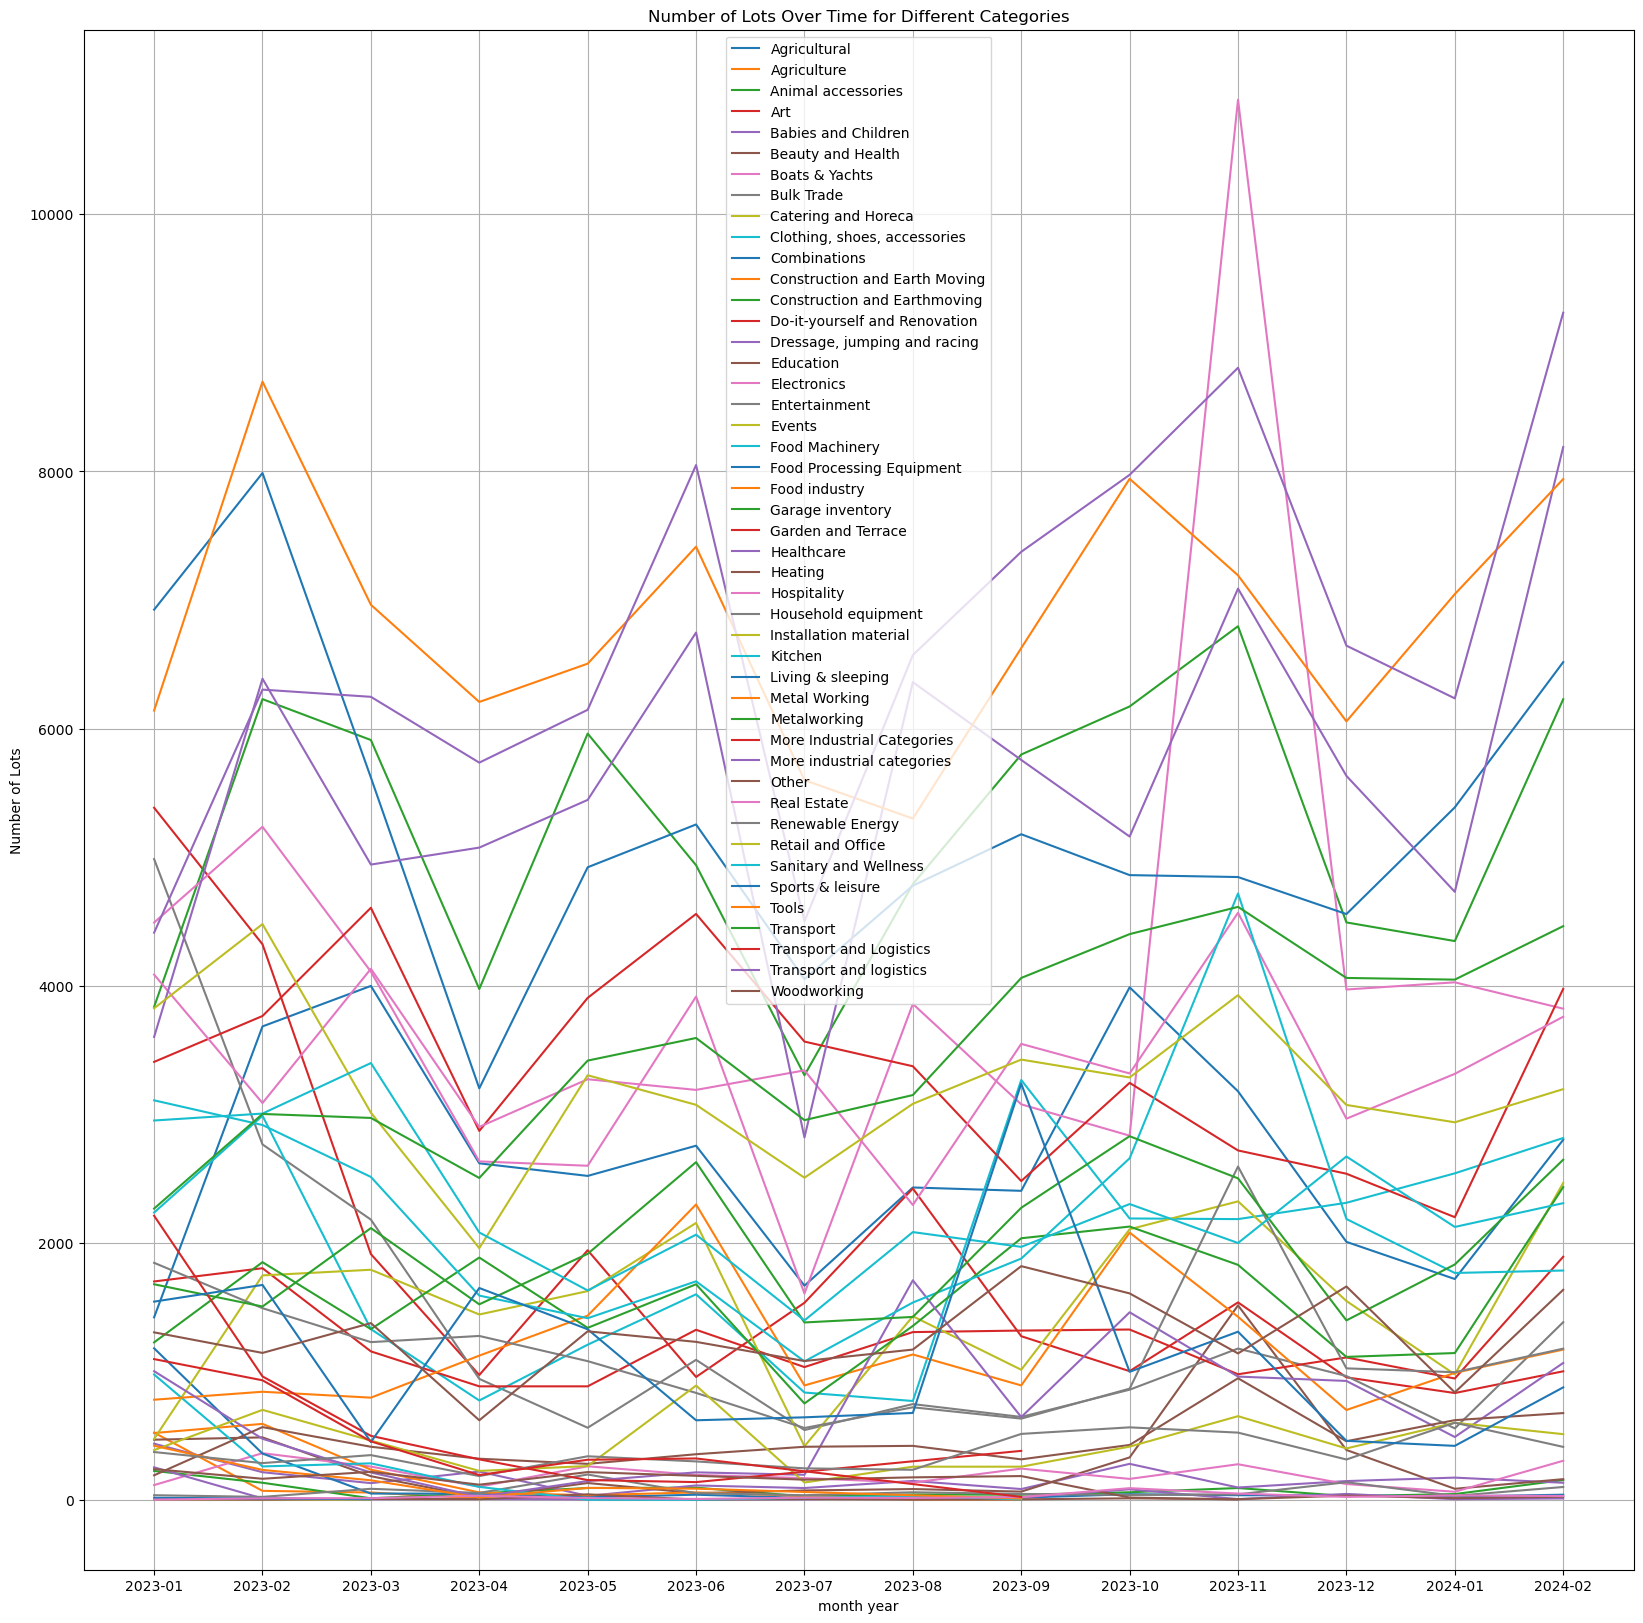

In [33]:
grouped_df = lots.groupby(['category_level_1', 'month_year']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(20, 20))

for category, group in grouped_df.groupby('category_level_1'):
    plt.plot(group['month_year'], group['count'], label=category)

plt.xlabel('month year')
plt.ylabel('Number of Lots')
plt.title('Number of Lots Over Time for Different Categories')
plt.legend()
plt.grid(True)
plt.show()

The figure above may be a bit to full of information, however for the scarcity we only need the categories with the lowest amount of lots. To create a better visualization of those categories, we only take the categories with an median amount of lots per month lower than 100. 

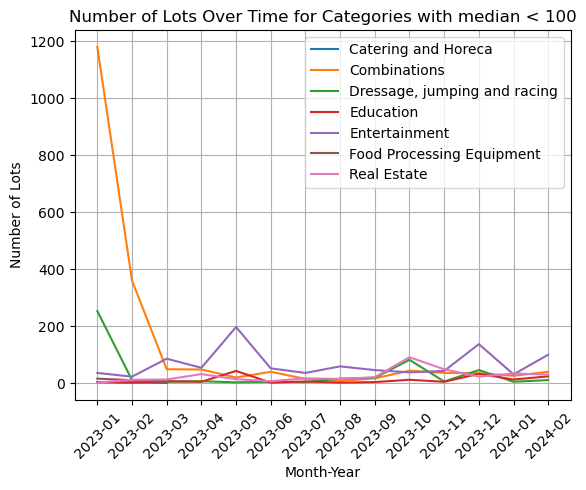

In [34]:
Grouped_category = lots.groupby(['category_level_1','month_year']).size().reset_index(name='count')
Grouped_category_filtered = Grouped_category.groupby('category_level_1')['count'].median().reset_index()
low_count_categories = Grouped_category_filtered[Grouped_category_filtered['count'] < 50]['category_level_1'] #Set boundary of 100
filtered_data = Grouped_category[Grouped_category['category_level_1'].isin(low_count_categories)]

for category, group in filtered_data.groupby('category_level_1'):
    plt.plot(group['month_year'], group['count'], label=category)


plt.xlabel('Month-Year')
plt.ylabel('Number of Lots')
plt.title('Number of Lots Over Time for Categories with median < 100')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Lets see how these auctions perform by looking at the number of bids and the ration between the end price and estimated price

In [35]:
Low_count=list(low_count_categories) #Creates list with all 'scarce' attributes
lots['scarce'] = lots['category_level_1'].apply(lambda x: 'yes' if x in Low_count else 'no') #Creates boolean column
lots

,lot_id,auction_id,auction_start_time,auction_close_time,lot_close_time_actual,estimated_price,starting_price,is_delivery,auction_country,lot_quantity,...,nr_bids,highest_valid_bid_amount,nr_valid_bid_users,log_auction_performance,auction_day_of_week,auction_month,category_level_1,ratio_estimate_actual,month_year,scarce
0,7700620,642088.0,2023-01-13 13:00:00,2023-02-14T13:15:00.000Z,2023-02-14T13:20:00.000Z,1000.0,50.0,0,HU,1.0,...,2.0,55.0,2.0,-1.514128,Friday,January,More Industrial Categories,0.055000,2023-01,no
1,8350850,781874.0,2023-09-01 15:00:00,2022-09-20T12:00:00.000Z,2022-09-20T12:00:00.000Z,400.0,200.0,0,BE,1.0,...,1.0,200.0,1.0,-0.693147,Friday,September,More Industrial Categories,0.500000,2023-09,no
2,8350874,781874.0,2023-09-01 15:00:00,2022-09-20T13:52:00.000Z,2022-09-20T13:54:00.000Z,200.0,100.0,0,BE,1.0,...,6.0,150.0,4.0,2.890372,Friday,September,More Industrial Categories,0.750000,2023-09,no
3,8461842,781874.0,2023-09-01 15:00:00,2022-09-20T12:30:00.000Z,2022-09-20T12:30:00.000Z,40.0,20.0,0,BE,1.0,...,23.0,220.0,6.0,6.632002,Friday,September,More Industrial Categories,5.500000,2023-09,no
4,8648157,804640.0,2023-02-06 14:00:00,2023-02-20T11:21:00.000Z,2023-02-20T11:21:00.000Z,200.0,100.0,0,UK,1.0,...,1.0,100.0,1.0,-0.693147,Monday,February,Metal Working,0.500000,2023-02,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046521,e5175da5-5e06-475b-acfb-ec75ce4b926c,1115902.0,2024-02-29 15:00:00,2024-03-11T13:00:00.000Z,NaN,200.0,10.0,0,NL,1.0,...,2.0,15.0,2.0,-1.203973,Thursday,February,Hospitality,0.075000,2024-02,no
1046522,fe2c8a03-2358-4f8f-9396-f26312986dce,1110712.0,2024-02-29 15:00:00,2024-03-14T18:00:00.000Z,NaN,250.0,50.0,0,NL,1.0,...,1.0,50.0,1.0,-1.609438,Thursday,February,Healthcare,0.200000,2024-02,no
1046523,353e0370-ccfc-4f4d-af02-d37121db90f1,1113571.0,2024-02-29 17:00:00,2024-03-07T15:00:00.000Z,NaN,850.0,850.0,0,BE,1.0,...,43.0,371.0,9.0,5.129390,Thursday,February,Sanitary and Wellness,0.436471,2024-02,no
1046524,6d3d0197-48a0-4ccd-8b9e-5cd47283c9e1,1103964.0,2024-02-27 18:00:00,2024-03-07T18:00:00.000Z,NaN,25000.0,4500.0,0,NL,1.0,...,65.0,27043.0,7.0,6.198850,Tuesday,February,Transport,1.081720,2024-02,no


In [36]:
#Create a column for the price ratio
lots['price_ratio']= lots['highest_valid_bid_amount']/lots['estimated_price']

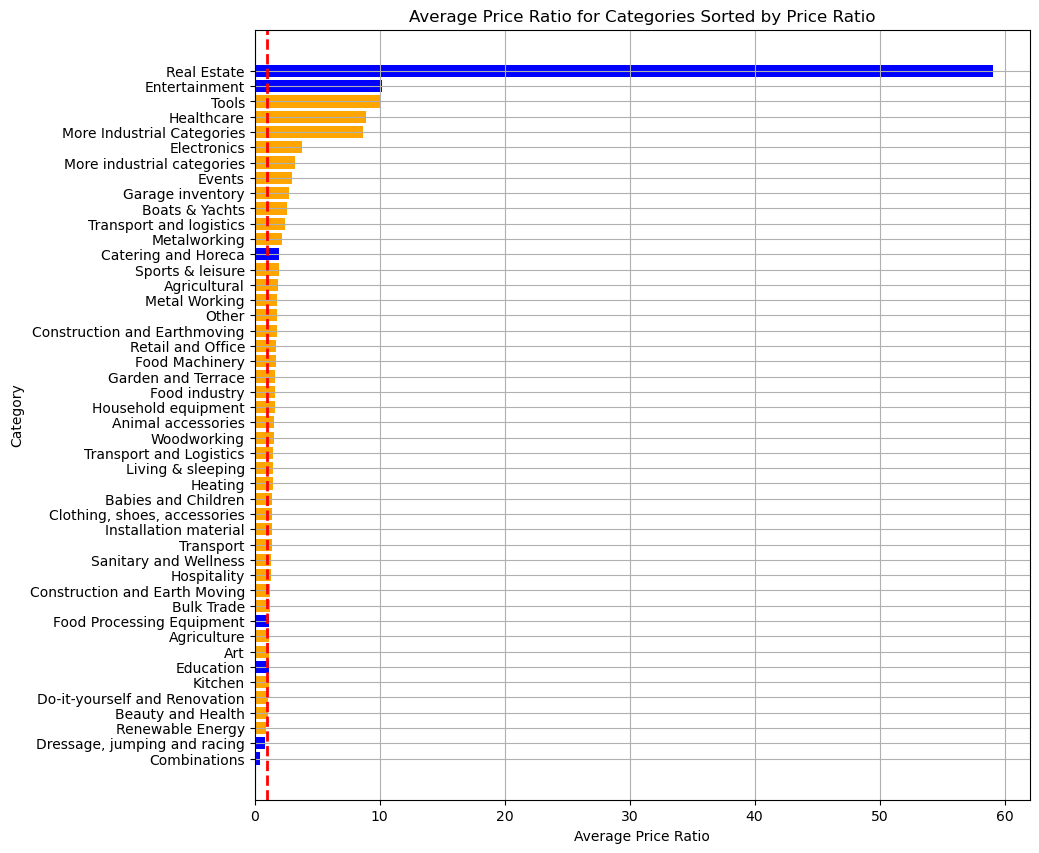

In [37]:
#Plot the price ratio as an performance metric
grouped_data = lots.groupby(['category_level_1', 'scarce'])['price_ratio'].mean().reset_index()
plt.figure(figsize=(10, 10))


sorted_data = grouped_data.sort_values(by='price_ratio')
plt.barh(sorted_data['category_level_1'], sorted_data['price_ratio'], color=sorted_data['scarce'].map({'yes': 'blue', 'no': 'orange'}))
plt.ylabel('Category')
plt.xlabel('Average Price Ratio')
plt.axvline(x=1, color='red', linestyle='--', linewidth=2) 
plt.title('Average Price Ratio for Categories Sorted by Price Ratio')
plt.grid(True)
plt.show()


From the graph above we see that 'Real estate' and 'entertainment' are two categories that are interesting to do more analyses on, because of their hiigh price ratio. On the other side of the graphs, we see 'Dressage, jumping and racing'. Which could be interesting because of the low price ratio. 

**Go further with the interesting categories**

In [55]:
Interesting_categories = ['Real Estate','Entertainment','Dressage, jumping and racing','Combinations']

#We merge category level 2 and 3 in the lots dataset
# Create a mapping from category_id to category_level_1
category_map2 = category_details.set_index('category_id')['category_level_2'].to_dict()
category_map3 = category_details.set_index('category_id')['category_level_3'].to_dict()


lots['category_level_2'] = lots['category_id'].map(category_map2)
lots['category_level_3'] = lots['category_id'].map(category_map3)



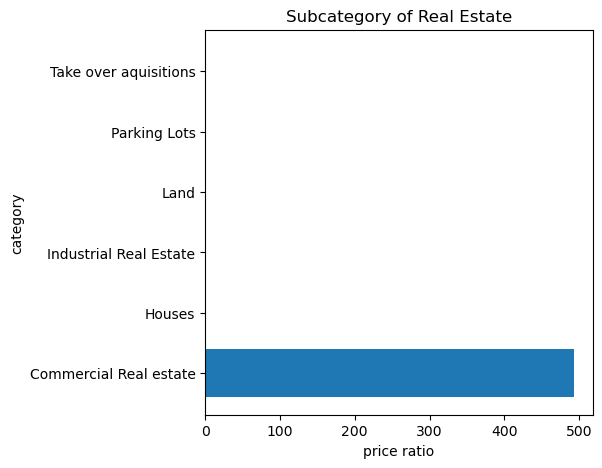

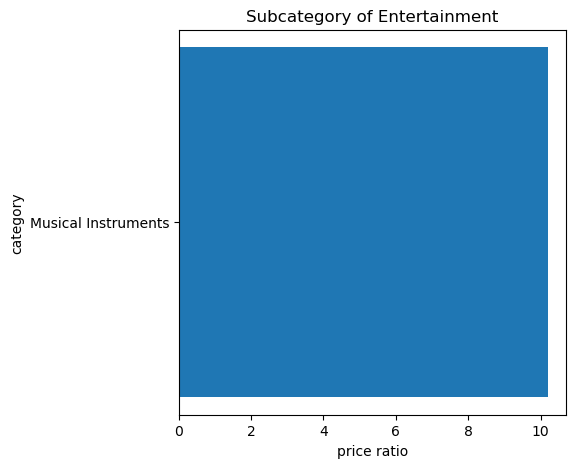

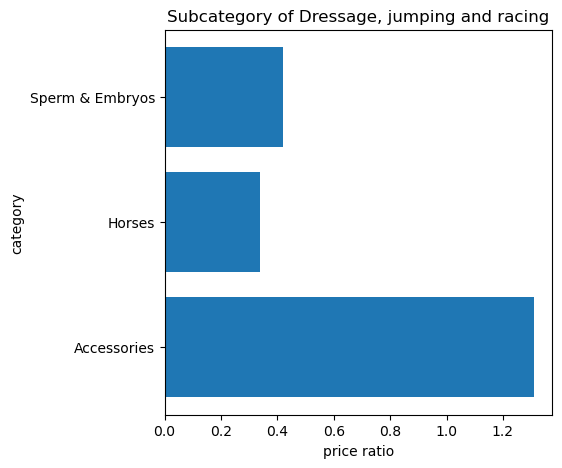

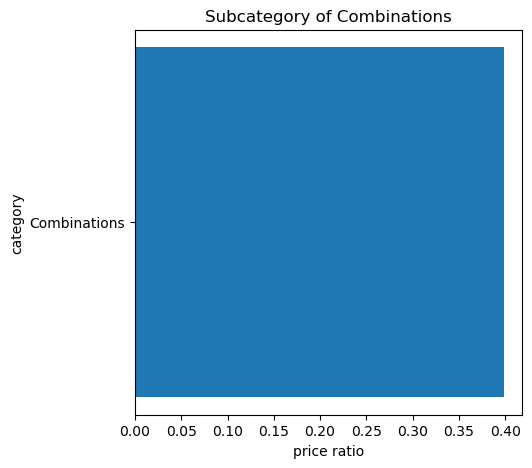

In [65]:
Interesting_data = lots[lots['category_level_1'].isin(Interesting_categories)]

for i in Interesting_categories:
    filtered_data = lots[lots['category_level_1'].isin([i])]
    Grouped_fil_dat = filtered_data.groupby(['category_level_2'])['price_ratio'].mean().reset_index()
    plt.figure(figsize=(5, 5))
    plt.barh(Grouped_fil_dat['category_level_2'],Grouped_fil_dat['price_ratio'])
    plt.xlabel('price ratio')
    plt.ylabel('category')
    plt.title('Subcategory of '+i)
